In [4]:
from google.colab import drive
drive.mount('/content/drive')

!tar xf drive/MyDrive/Colab\ Notebooks/data/mnist-png-format-permutated.tar.xz -C /content/

Mounted at /content/drive


Enable CUDA for GPU acceleration 


In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


Validation and accuracy Plot function

In [5]:
import matplotlib.pyplot as plt
def plot(t_acc, t_loss, v_acc, v_loss):
  epochs = [*range(1,len(t_acc)+1, 1)]

  fig, axes = plt.subplots(1,2, figsize=(10,3))
  axes[0].plot(epochs, t_acc, label='Training Accuracy')
  axes[0].plot(epochs, v_acc, label='Validation Accuracy')
  axes[0].set_title('Accuracy')
  axes[0].legend()
 
  axes[1].plot(epochs, t_loss, label='Training loss')
  axes[1].plot(epochs, v_loss, label='Validation loss')
  axes[1].set_title('Loss')
  axes[1].legend()

  fig.tight_layout()
  plt.show()


Import data in PNG form and split into Train, Test, Validate and load


In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale

train_set = '/content/mnist-png-format-permutated/train'
test_set = '/content/mnist-png-format-permutated/test'

batch_size = 128
workers = 0

transforms = Compose([
                        Grayscale(num_output_channels=1),   # PNG file is RGB 3 layer convert to greyscal 1 layer
                        ToTensor(),           
                        Normalize(mean=(0.5), std=(0.5)), 
                        ])

train_dataset = ImageFolder(train_set, transform=transforms)
test_dataset = ImageFolder(test_set, transform=transforms)

#train_dataset = torch.utils.data.random_split(train_dataset, [20000, len(train_dataset)-20000])[0]

# Split Train dataset set into two (Train=85/Validation=15% split)
train_size = int(len(train_dataset) * 0.85) 
validation_size = (len(train_dataset) - train_size) 
train, validation = random_split(train_dataset, [train_size, validation_size])

# load data into usable format, mix/shuffle data so data is not in order 
train_data = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
val_data  = DataLoader(validation, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory=True)
test_data  = DataLoader(test_dataset, batch_size = batch_size, num_workers = workers, pin_memory=True)

In [7]:
from torch import nn, optim

class SingleLayerModel(nn.Module):
    def __init__(self, neurons):
        super().__init__()
        self.hidden_1 = nn.Linear(28*28, neurons) # 28x28 Input image, number of neurons
        self.output = nn.Linear(neurons, 10) # 10 class output 0-9


    def forward(self, x):
        x = x.view(x.shape[0], -1) 
        x = nn.functional.relu(self.hidden_1(x))
        y = self.output(x)
        return y

In [8]:
def evaluate_model(model, eval_dataset):
    model = model.to(device)
    model.eval() # Set model mode to evaluation not training
    correct_batch = 0
    loss_batch = 0
    with torch.no_grad():                 # Gradient graph not require for evaluation should reduce memory usage
      for (imgs, labels) in eval_dataset: # loop through each batch
        imgs, labels = imgs.to(device), labels.to(device)

        pred_y = model(imgs)
        loss = loss_func(pred_y, labels)

        pred = torch.max(pred_y, 1)[1]
        correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
        loss_batch += loss.item()

    return correct_batch / len(eval_dataset.dataset), loss_batch / len(eval_dataset.dataset)

In [9]:
def train_model(model, train_dataset, eval_dataset, epochs):
  train_acc, train_loss = [], []
  val_acc,   val_loss   = [], []

  model = model.to(device)
    
  for i in range(epochs): # training epochs
    correct_batch = 0
    loss_batch    = 0

    for (imgs, labels) in train_dataset: # loop through each batch 
      imgs, labels = imgs.to(device), labels.to(device)
      model.train()
      pred_y = model(imgs)
      loss = loss_func(pred_y, labels)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

      pred = torch.max(pred_y, 1)[1]
      correct_batch += (pred == labels).sum().item() # Calculate correct prediction where prediction == label 
      loss_batch += loss.item()

    v_acc, v_loss = evaluate_model(model, eval_dataset)
    val_acc.append(v_acc)
    val_loss.append(v_loss)
    train_acc.append(correct_batch / len(train_dataset.dataset))
    train_loss.append(loss_batch / len(train_dataset.dataset))

    print('  Train accuracy = {0:.2%}, Train loss = {1:.6f} \
            Validation accuracy = {2:.2%}, Validation loss = {3:.6f}'.format(train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1] ))
  
  return train_acc, train_loss, val_acc, val_loss

Define Optimisable parameter to test for optimal accuracy

  Train accuracy = 86.58%, Train loss = 0.003711             Validation accuracy = 90.71%, Validation loss = 0.002498
  Train accuracy = 92.12%, Train loss = 0.002112             Validation accuracy = 93.17%, Validation loss = 0.001867
  Train accuracy = 94.04%, Train loss = 0.001624             Validation accuracy = 94.27%, Validation loss = 0.001489
  Train accuracy = 95.16%, Train loss = 0.001309             Validation accuracy = 95.29%, Validation loss = 0.001292
  Train accuracy = 95.95%, Train loss = 0.001105             Validation accuracy = 95.52%, Validation loss = 0.001209
  Train accuracy = 96.52%, Train loss = 0.000958             Validation accuracy = 96.17%, Validation loss = 0.001011
  Train accuracy = 96.82%, Train loss = 0.000850             Validation accuracy = 96.46%, Validation loss = 0.000922
  Train accuracy = 97.12%, Train loss = 0.000755             Validation accuracy = 96.30%, Validation loss = 0.000924
  Train accuracy = 97.31%, Train loss = 0.000694        

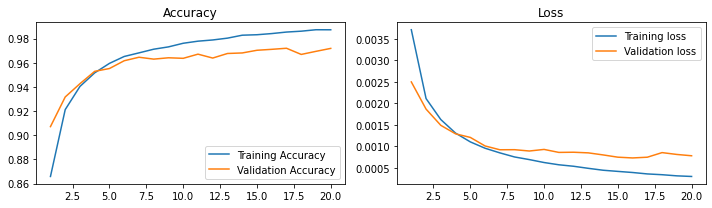

In [16]:
# Optimisable parameters
learning_rate = 0.001
train_epochs = 20
neurons = 100

loss_func = nn.CrossEntropyLoss()

model_n = SingleLayerModel(neurons)
optimiser = optim.Adam(model_n.parameters(), lr=learning_rate)
results = train_model(model_n, train_data, val_data, train_epochs)
plot(*results)

Run model on test set to get True model accuracy

In [17]:
test, _ = evaluate_model(model_n, test_data)
print('Test accuracy = {0:.2%}'.format(test))

Test accuracy = 97.29%


**Results MLP Permutated** 

Permutated Data set Applied on the best model found in task_02b

Model parameters  = Training with Neurons = 100, Learning rate = 0.001, Epochs = 20

MNIST Test accuracy = 94.93%
MNIST Permutated Test accuracy = **97.29%**

Surprisingly the permutated dataset has a slight higher accuracy I have a feeling that the performance is equal to that of the ordinary MNIST it is just a minor Variation in training that caused the different.

Explanation: As the MLP does not take into account the location of each pixel the result to mixing/permutating does little to effect the performance in contrast to a CNN who is using knowledge of neighbouring pixels. I assume the permutation done on the MNIST are consistently applied therefore in the eyes of the MLP there is little difference in the data set.


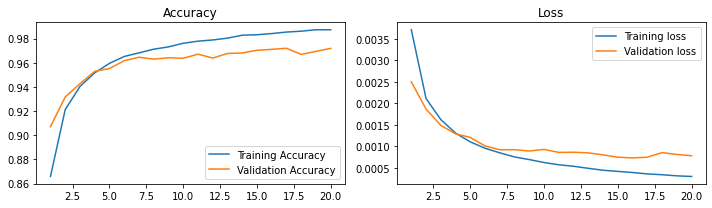